In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from copy import deepcopy
import seaborn as sns

In [2]:
class GridSquare:
    def __init__(self, can_place, cost, free_wind_speed):
        self.can_place = can_place
        self.has_turbine = False
        self.cost = cost
        self.power = 0
        self.wind_speed = free_wind_speed
    
    def __str__(self):
        return f'Has turbine: {self.has_turbine}; can_place: {self.can_place}; cost: {self.cost}; wind_speed: {self.wind_speed}; power: {self.power}'
    
    def __repr__(self):
        return f'Has turbine: {self.has_turbine}; can_place: {self.can_place}; cost: {self.cost}; wind_speed: {self.wind_speed}; power: {self.power}'
        
    def add_turbine():
        self.has_turbine = True
        
    def remove_turbine():
        self.has_turbine = False
        
    def set_power(power):
        self.power = power
        
    def set_wind_speed(wind_speed):
        self.wind_speed = wind_speed
    

In [3]:
def get_grid_power(grid):
    n_rows = len(grid)
    n_cols = len(grid[0])
    
    power_grid = [[] for i in range(n_rows)]
    
    for i in range(n_rows):
        for j in range(n_cols):
            power_grid[i].append(grid[i][j].power)
    
    return power_grid

def get_grid_wind_speed(grid):
    n_rows = len(grid)
    n_cols = len(grid[0])
    
    wind_speed_grid = [[] for i in range(n_rows)]
    
    for i in range(n_rows):
        for j in range(n_cols):
            wind_speed_grid[i].append(grid[i][j].wind_speed)
    
    return wind_speed_grid

def get_grid_cost(grid):
    n_rows = len(grid)
    n_cols = len(grid[0])
    
    cost_grid = [[] for i in range(n_rows)]
    
    for i in range(n_rows):
        for j in range(n_cols):
            cost_grid[i].append(grid[i][j].cost)
    
    return cost_grid

In [4]:
def get_original_grid(free_wind_speed):

    np.random.seed(1)
    turbine_cost = 500
    initial_budget = 5000
    n_rows = 5
    n_cols = 5

    grid_orig = [[] for i in range(n_cols)]
    grid_cost = np.random.normal(100, 20, [5,5])
    threshold = 0.2 

    for i in range(n_rows):
        for j in range(n_cols):

            can_place = True if np.random.uniform(0,1) > threshold else False
            square =  GridSquare(can_place, grid_cost[i,j]+turbine_cost, free_wind_speed)
            grid_orig[i].append(square)
    
    return grid_orig



In [5]:
power_curve_df = pd.read_excel('../WomenHackCPH -data.xlsx', sheet_name='Power Curve', header=1)
power_curve_df.head()

,wind speed,Power,Cp,Ct,Unnamed: 4,rotor dimater,136,hub height,132
0,2.5,0.0,0.00,0.000,NaN,NaN,NaN,NaN,NaN
1,3.0,34.5,0.15,0.750,NaN,NaN,NaN,NaN,NaN
2,3.5,113.3,0.30,0.797,NaN,NaN,NaN,NaN,NaN
3,4.0,211.8,0.37,0.807,NaN,NaN,NaN,NaN,NaN
4,4.5,329.9,0.41,0.807,NaN,NaN,NaN,NaN,NaN


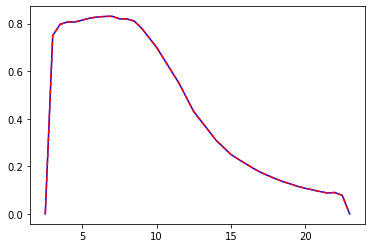

In [6]:
thrust_interp = CubicSpline(power_curve_df['wind speed'].values, power_curve_df['Ct'].values, bc_type='natural')


fig, ax = plt.subplots()
plt.plot(power_curve_df['wind speed'].values, power_curve_df['Ct'].values, color='blue')
plt.plot(power_curve_df['wind speed'].values, thrust_interp(power_curve_df['wind speed'].values), color='red',linestyle='--')


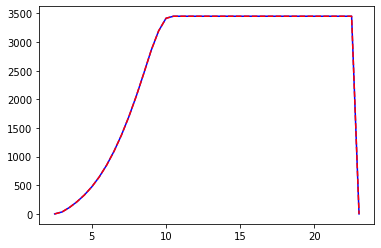

In [7]:
power_interp = CubicSpline(power_curve_df['wind speed'].values, power_curve_df['Power'].values, bc_type='natural')


fig, ax = plt.subplots()
plt.plot(power_curve_df['wind speed'].values, power_curve_df['Power'].values, color='blue')
plt.plot(power_curve_df['wind speed'].values, power_interp(power_curve_df['wind speed'].values), color='red', linestyle='--')


In [8]:
def get_power(power_interp, wind_speed):
    #do interpolation to get power for given wind speed
    power = power_interp(wind_speed)
    return power

def get_thrust(thrust_interp, wind_speed):
    #do interpolation to get power for given wind speed
    thrust = thrust_interp(wind_speed)
    
    return thrust

In [30]:
def calculate_current_power(grid_orig, free_wind_speed, power_interp, thrust_interp):
    """
    grid: matrix, where each entry is a square object
    power_curve:
    """
    
    grid = deepcopy(grid_orig)
    rotor_diameter = 0.2
    k = 0.04
    
    n_rows = len(grid)  # y direction
    n_cols = len(grid[0])  # x direction
    
    
    for turb_y in range(n_rows):
        for turb_x in range(n_cols):
    
            sum_speed_red = 0
            
            if grid[turb_y][turb_x].has_turbine:    
                for y in range(n_rows):
                    for x in range(turb_x):
                        
                        if grid[y][x].has_turbine:
                            dx = np.abs(turb_x-x)
                            dy = np.abs(turb_y-y)
                            dw = rotor_diameter + 2*k*dx
                            
                            if (dw + rotor_diameter)/ 2 > dy:
                                # taking overlap as the ratio of dw/dy
                                overlap = 1 if dy == 0 else dw / dy
                                                    
                                thrust = get_thrust(thrust_interp, grid[y][x].wind_speed)
                                delta = overlap * grid[y][x].wind_speed * ( (1-np.sqrt(1-thrust)) / ((1 + 2*k*dx / rotor_diameter)))
                                sum_speed_red += np.abs(delta) ** 2
            
                if sum_speed_red > 0:
                    sum_speed_red = np.sqrt(sum_speed_red)                

                wind_speed = free_wind_speed - sum_speed_red
                grid[turb_y][turb_x].wind_speed = wind_speed
                grid[turb_y][turb_x].power = get_power(power_interp, wind_speed)
                
    
    return grid

In [31]:
free_wind_speed = 12
grid_orig = get_original_grid(free_wind_speed)

In [32]:
turbines_pos = np.array([[2, 0],
                       [2, 1],
                       [2, 2],
                       [1,2],
                       [1,4],
                       [0, 4],
                       [4, 4]])
turbines_pos

array([[2, 0],
       [2, 1],
       [2, 2],
       [1, 2],
       [1, 4],
       [0, 4],
       [4, 4]])

In [33]:
for pos in turbines_pos:
    grid_orig[pos[0]][pos[1]].has_turbine = True


In [34]:
grid = calculate_current_power(grid_orig, free_wind_speed, power_interp, thrust_interp)

In [35]:
grid

[[Has turbine: False; can_place: False; cost: 632.4869072732648; wind_speed: 12; power: 0,
  Has turbine: False; can_place: True; cost: 587.7648717269985; wind_speed: 12; power: 0,
  Has turbine: False; can_place: True; cost: 589.4365649547309; wind_speed: 12; power: 0,
  Has turbine: False; can_place: True; cost: 578.5406275568766; wind_speed: 12; power: 0,
  Has turbine: True; can_place: True; cost: 617.3081525864936; wind_speed: 12; power: 3450.0],
 [Has turbine: False; can_place: False; cost: 553.9692260623943; wind_speed: 12; power: 0,
  Has turbine: False; can_place: False; cost: 634.8962352843296; wind_speed: 12; power: 0,
  Has turbine: True; can_place: True; cost: 584.7758619820979; wind_speed: 12; power: 3450.0,
  Has turbine: False; can_place: True; cost: 606.380781921142; wind_speed: 12; power: 0,
  Has turbine: True; can_place: True; cost: 595.0125924904518; wind_speed: 10.094285619028566; power: 3432.8884855413985],
 [Has turbine: True; can_place: True; cost: 629.24215874

In [36]:
power_grid = get_grid_power(grid)
wind_speed_grid = get_grid_wind_speed(grid)
cost_grid = get_grid_cost(grid)

In [37]:
pos_map = np.zeros([5,5])
for pos in turbines_pos:
    pos_map[pos[0]][pos[1]] = 1


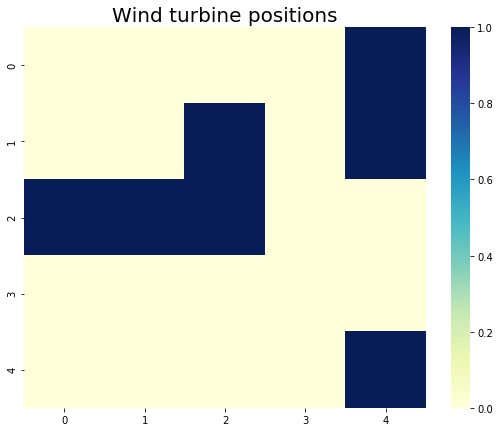

In [64]:
fig, ax = plt.subplots(1, figsize=(9,7))
sns.heatmap(data=pos_map,  cmap="YlGnBu", ax=ax);
plt.title('Wind turbine positions', size=20);

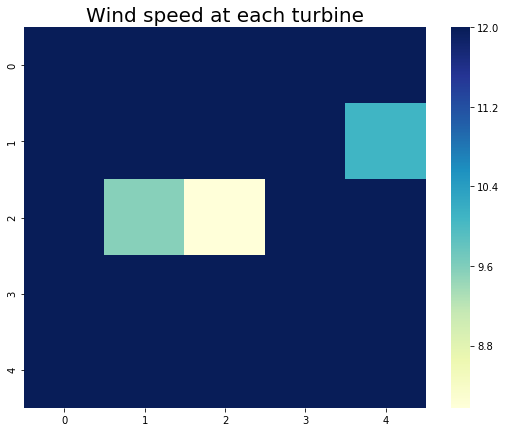

In [63]:
fig, ax = plt.subplots(1, figsize=(9,7))
sns.heatmap(data=wind_speed_grid,  cmap="YlGnBu", ax=ax);
plt.title('Wind speed at each turbine', size=20);

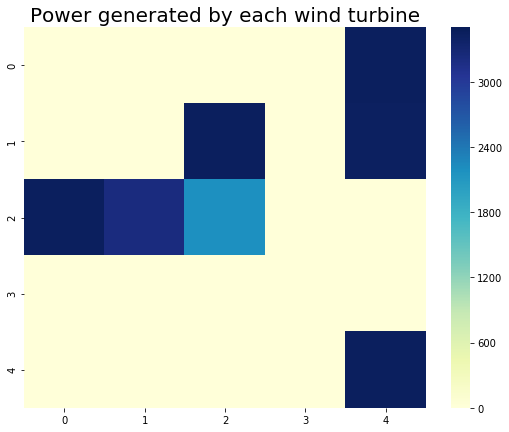

In [66]:
fig, ax = plt.subplots(1, figsize=(9,7))
sns.heatmap(data=power_grid,  cmap="YlGnBu", vmin=0, vmax=3500, ax=ax);
plt.title('Power generated by each wind turbine', size=20);

In [41]:
np.sum(power_grid)

22646.232854853988